In [1]:
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import gmsh

plt.rcdefaults()
plt.style.use('seaborn-v0_8-paper')
plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

from ttcrpy.rgrid import Grid2d
from ttcrpy.tmesh import Mesh2d

# Example 5 - anisotropy

Anisotropy has been implemented for the Shortest-Path method, for 2D grids and meshes.  This notebook shows two examples.

### 5.1 Elliptical anisotropy on a rectilinear grid

Traveltimes are compared to the analytic expression of Rogister & Slawinski, 2005 (doi: 10.1190/1.2049347)

/var/folders/kd/v1qqm8qd15506q5jp_2tz_bw0000gn/T/ipykernel_72131/3244655849.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tt = grid.raytrace(src, rcv)


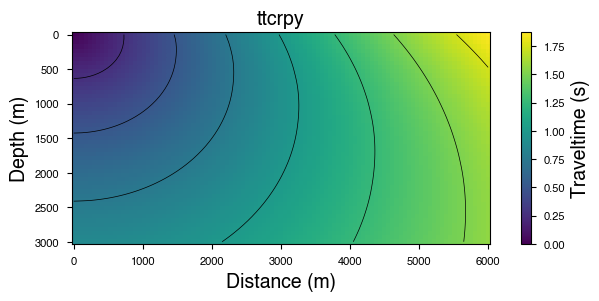

In [2]:
# grid node coordinates

x = np.arange(0.0, 6000.01, 60.0)
z = np.arange(0.0, 3000.01, 60.0)

grid = Grid2d(x, z, method='SPM', aniso='elliptical', nsnx=10, nsnz=10)

a = 2271.0
b = 0.88
chi = 0.3

src = np.array([[0.0, 0.0]])
rcv = np.c_[np.kron(x, np.ones((z.size,))).reshape(-1, 1),
            np.kron(np.ones((x.size,)), z).reshape(-1, 1)]

# coordinates at center of cells

xc = np.arange(30.0, 6000.0, 60.0)
zc = np.arange(30.0, 3000.0, 60.0)

xx, zz = np.meshgrid(xc, zc)

vz = a + b*zz
vx = np.sqrt( chi * 2 * vz**2 + vz**2)

sx = 1/vx
sz = 1/vz

xi = sz / sx  # anisotropy ratio

grid.set_slowness(sx.flatten(order='F'))  # we use horizontal slowness with ttcrpy's implementation
grid.set_xi(xi.flatten(order='F'))

tt = grid.raytrace(src, rcv)
tt = tt.reshape((x.size, z.size)).T

xx, zz = np.meshgrid(x, z)

plt.figure(figsize=(7,3))
h = plt.pcolor(xx, zz, tt)
plt.contour(xx, zz, tt, colors='k', linewidths=0.5)
plt.xlabel('Distance (m)', fontsize=14)
plt.ylabel('Depth (m)', fontsize=14)
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
cb = plt.colorbar(h)
cb.set_label('Traveltime (s)', fontsize=14)
plt.title('ttcrpy', fontsize=14)
plt.tight_layout()
plt.show()


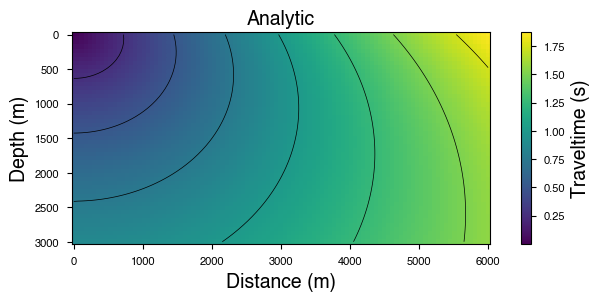

In [3]:
# now use analytic expression
# set to 1 mm to avoid numerical issues at x = 0
x[0] = 0.001

xx, zz = np.meshgrid(x, z)

p = 2*xx / np.sqrt((xx*xx + (1+2*chi) * zz*zz) *
                  ((2*a + b*zz)**2 * (1+2*chi) + b*b * xx*xx))

tt_a = 1/b * (np.arctanh(p * b * xx - np.sqrt(1 - (1+2*chi) * p*p * a*a)) +
              np.arctanh(np.sqrt(1 - (1+2*chi) * p*p * a*a)))


plt.figure(figsize=(7,3))
h = plt.pcolor(xx, zz, tt_a)
plt.contour(xx, zz, tt_a, colors='k', linewidths=0.5)
plt.xlabel('Distance (m)', fontsize=14)
plt.ylabel('Depth (m)', fontsize=14)
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
cb = plt.colorbar(h)
cb.set_label('Traveltime (s)', fontsize=14)
plt.title('Analytic', fontsize=14)
plt.tight_layout()
plt.show()


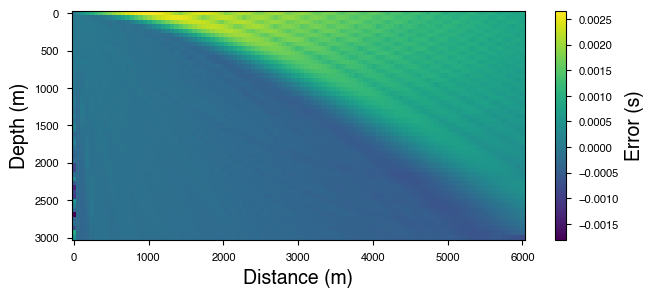

In [4]:
error = tt_a - tt

plt.figure(figsize=(7,3))
h = plt.pcolor(xx, zz, error)
plt.xlabel('Distance (m)', fontsize=14)
plt.ylabel('Depth (m)', fontsize=14)
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
cb = plt.colorbar(h)
cb.set_label('Error (s)', fontsize=14)
plt.tight_layout()
plt.show()


### 5.2 Weakly anelliptical anisotropy on triangular meshes

In this section, we are looking at the formulation of Björn Rommel (https://github.com/bjornrommel/steinkauz/tree/master/project/ambiguity).

Using gmsh, we will build a model as the one used to produce Fig 7 of the paper.  The model properties were obtained for Björn's GitHub repo.  A fourth layer was added with arbitrary properties.

In [5]:
# layer parameters
# <name of layer> = {
#   'name': any, but a unique name
#   'key': 'generic'
#   'vvv0': reference velocity
#   'rrr2': 2. phase-velocity coefficient
#   'rrr4': 4. phase-velocity coefficient
#   'tilt': tilt of symmetry axis
#   'thick': thickness of a layer measured along the vertical
#   'depth': depth of a reflector measured along the vertical below the source
#   'dip': dip of a reflector, with positive for dipping downwards
#   'ggg': stretch factor
# units of times and distances are arbitrary, but must be applied consistently
# units of angles are degree
# use key': 'generic' for now until epsilon, delta, etc are implemented; see
# also the class Layer

OVERBURDEN = {
    'name': 'overburden',
    'key': 'generic',
    'vvv0': 330.,
    'rrr2': 0.2,
    'rrr4': -0.3,
    'thick': 500.,
    'dip': +10.,
    'ggg': 0.5}
ROCK = {
    'name': 'rock',
    'key': 'generic',
    'vvv0': 1000.,
    'rrr2': -0.2,
    'rrr4': 0.1,
    'thick': 1500.,
    'dip': -5.,
    'ggg': -0.}
TARGET = {
    'name': 'target',
    'key': 'generic',
    'vvv0': 1500.,
    'rrr2': -0.3,
    'rrr4': -0.2,
    'thick': 1400.,
    'dip': -15.,
    'ggg': 0.}

BEDROCK = {
    'name': 'bedrock',
    'key': 'generic',
    'vvv0': 2000.,
    'rrr2': 0.0,
    'rrr4': 0.0,
    'thick': 1400.,
    'dip': -15.,
    'ggg': 0.}


In [6]:
def to_energy(rock):
    # from ttwean.py found @ https://github.com/bjornrommel/steinkauz/tree/master/project/ambiguity
    r2 = rock['rrr2']
    r4 = rock['rrr4']
    t2 = r2 / (1. + r2)
    t4 = ((r2 ** 2 * (1. + r2) ** 2 + r4) / (1. + r2) ** 4)
    rock['sss2'] = t2 / 2.
    rock['sss4'] = -1. * t2 ** 2 / 8. + t4 / 2.
    
to_energy(OVERBURDEN)
to_energy(ROCK)
to_energy(TARGET)
to_energy(BEDROCK)

In [7]:
gmsh.initialize()

gmsh.clear()
mesh_size = 75.0

xmin = -2000.0
xmax = 4500.0
zmin = 0.0
zmax = 4000.0

p1 = gmsh.model.geo.addPoint(xmin, 0.0, zmin, meshSize=mesh_size)
p2 = gmsh.model.geo.addPoint(xmax, 0.0, zmin, meshSize=mesh_size)
z = OVERBURDEN['thick'] + xmax * np.arctan(np.pi/180*OVERBURDEN['dip'])
p3 = gmsh.model.geo.addPoint(xmax, 0.0, z, meshSize=mesh_size)
z = OVERBURDEN['thick'] + xmin * np.arctan(np.pi/180*OVERBURDEN['dip'])
p4 = gmsh.model.geo.addPoint(xmin, 0.0, z, meshSize=mesh_size)

z = OVERBURDEN['thick'] + ROCK['thick'] + xmax * np.arctan(np.pi/180*ROCK['dip'])
p5 = gmsh.model.geo.addPoint(xmax, 0.0, z, meshSize=mesh_size)
z = OVERBURDEN['thick'] + ROCK['thick'] + xmin * np.arctan(np.pi/180*ROCK['dip'])
p6 = gmsh.model.geo.addPoint(xmin, 0.0, z, meshSize=mesh_size)

z = OVERBURDEN['thick'] + ROCK['thick'] + TARGET['thick'] + xmax * np.arctan(np.pi/180*TARGET['dip'])
p7 = gmsh.model.geo.addPoint(xmax, 0.0, z, meshSize=mesh_size)
z = OVERBURDEN['thick'] + ROCK['thick'] + TARGET['thick'] + xmin * np.arctan(np.pi/180*TARGET['dip'])
p8 = gmsh.model.geo.addPoint(xmin, 0.0, z, meshSize=mesh_size)

p9  = gmsh.model.geo.addPoint(xmax, 0.0, zmax, meshSize=mesh_size)
p10 = gmsh.model.geo.addPoint(xmin, 0.0, zmax, meshSize=mesh_size)

l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p1)

l5 = gmsh.model.geo.addLine(p3, p5)
l6 = gmsh.model.geo.addLine(p5, p6)
l7 = gmsh.model.geo.addLine(p6, p4)

l8  = gmsh.model.geo.addLine(p5, p7)
l9  = gmsh.model.geo.addLine(p7, p8)
l10 = gmsh.model.geo.addLine(p8, p6)

l11 = gmsh.model.geo.addLine(p7, p9)
l12 = gmsh.model.geo.addLine(p9, p10)
l13 = gmsh.model.geo.addLine(p10, p8)

ll1 = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])
ll2 = gmsh.model.geo.addCurveLoop([-l3, l5, l6, l7])
ll3 = gmsh.model.geo.addCurveLoop([-l6, l8, l9, l10])
ll4 = gmsh.model.geo.addCurveLoop([-l9, l11, l12, l13])

s1 = gmsh.model.geo.addPlaneSurface([ll1])
s2 = gmsh.model.geo.addPlaneSurface([ll2])
s3 = gmsh.model.geo.addPlaneSurface([ll3])
s4 = gmsh.model.geo.addPlaneSurface([ll4])

gmsh.model.geo.synchronize()

ps1 = gmsh.model.addPhysicalGroup(2, [s1])
ps2 = gmsh.model.addPhysicalGroup(2, [s2])
ps3 = gmsh.model.addPhysicalGroup(2, [s3])
ps4 = gmsh.model.addPhysicalGroup(2, [s4])

gmsh.model.setPhysicalName(2, ps1, OVERBURDEN['name'])
gmsh.model.setPhysicalName(2, ps2, ROCK['name'])
gmsh.model.setPhysicalName(2, ps3, TARGET['name'])
gmsh.model.setPhysicalName(2, ps4, BEDROCK['name'])

# We can then generate a 2D mesh...
gmsh.model.mesh.generate(2)

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 40%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 70%] Meshing curve 9 (Line)
Info    : [ 70%] Meshing curve 10 (Line)
Info    : [ 80%] Meshing curve 11 (Line)
Info    : [ 90%] Meshing curve 12 (Line)
Info    : [100%] Meshing curve 13 (Line)
Info    : Done meshing 1D (Wall 0.000512708s, CPU 0.000515s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 30%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 80%] Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0

In [8]:
# get indices of nodes forming the triangles of the mesh
triangles = []
physical_model = []
nodeTags, coord, parametricCoord = gmsh.model.mesh.getNodes()

for dim, tag in gmsh.model.getEntities(dim=2):
    physicalTags = gmsh.model.getPhysicalGroupsForEntity(dim, tag)
    elemTypes, elemTags, elemNodeTags = gmsh.model.mesh.getElements(dim, tag)
    for n in range(len(elemTags[0])):
        t = elemNodeTags[0][3*n:(3*n+3)]
        triangles.append(t)
        physical_model.append(physicalTags[0] - 1)

triangles = np.array(triangles) - 1  # convert to numpy array and set start index to 0 instead of 1
nodes = np.array(coord).reshape((len(nodeTags), 3))
nodes = np.c_[nodes[:, 0], nodes[:, 2]]  # keep only x & z
physical_model = np.array(physical_model)


In [9]:
gmsh.finalize()  # we're done with gmsh

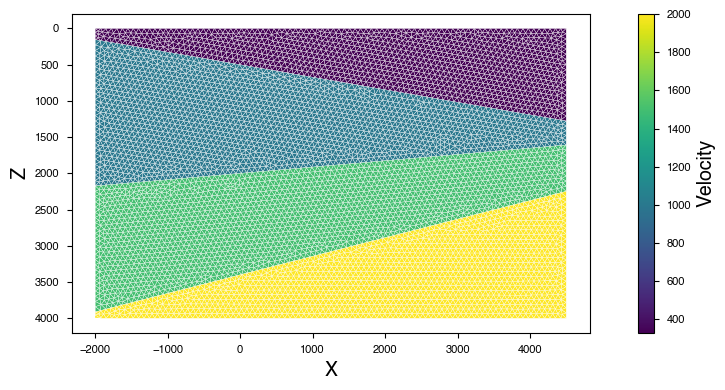

In [10]:
V = np.empty(physical_model.shape)
V[physical_model == 0] = OVERBURDEN['vvv0']
V[physical_model == 1] = ROCK['vvv0']
V[physical_model == 2] = TARGET['vvv0']
V[physical_model == 3] = BEDROCK['vvv0']

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

tpc = ax.tripcolor(nodes[:, 0], nodes[:, 1], triangles, V, edgecolors='w')
cbar = plt.colorbar(tpc, ax=ax)
cbar.ax.set_ylabel('Velocity', fontsize=14)

ax.invert_yaxis()
ax.set_aspect('equal')

plt.xlabel('X', fontsize=14)
plt.ylabel('Z', fontsize=14)
plt.tight_layout()
plt.show()

In [11]:
Tx = np.array([[0.0, 0.0]])  # place the source
Rx = np.array([[4000.0, 0.0]])

# create the mesh (values in trangles are unsigned long, we must pass int)
mesh = Mesh2d(nodes, triangles.astype(np.int64), method='SPM', n_secondary=10, aniso='weakly_anelliptical')

s2 = np.empty(physical_model.shape)
s2[physical_model == 0] = OVERBURDEN['sss2']
s2[physical_model == 1] = ROCK['sss2']
s2[physical_model == 2] = TARGET['sss2']
s2[physical_model == 3] = BEDROCK['sss2']

s4 = np.empty(physical_model.shape)
s4[physical_model == 0] = OVERBURDEN['sss4']
s4[physical_model == 1] = ROCK['sss4']
s4[physical_model == 2] = TARGET['sss4']
s4[physical_model == 3] = BEDROCK['sss4']

mesh.set_slowness(1/V)   # With this implementation of weakly anelliptical anisotropy,
                         # we must use slowness in the vertical direction
mesh.set_s2(s2)
mesh.set_s4(s4)

tt = mesh.raytrace(Tx, Rx)

/var/folders/kd/v1qqm8qd15506q5jp_2tz_bw0000gn/T/ipykernel_72131/815355484.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tt = mesh.raytrace(Tx, Rx)


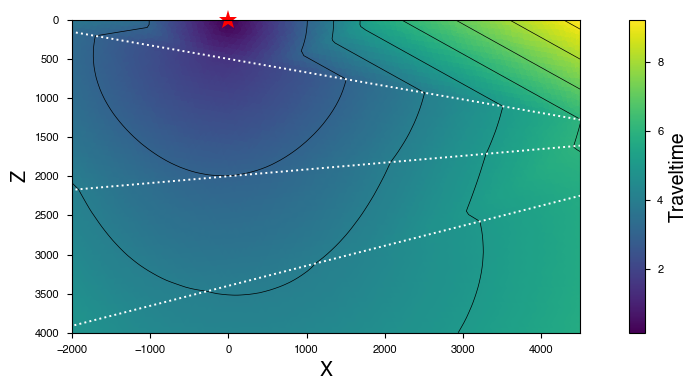

In [12]:
mesh_tt = mesh.get_grid_traveltimes()

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

tpc = ax.tripcolor(nodes[:, 0], nodes[:, 1], triangles, mesh_tt)
ax.tricontour(nodes[:, 0], nodes[:, 1], mesh_tt, levels=np.arange(3, 10),
              colors='k', linewidths=0.5)
ax.plot((nodes[2,0], nodes[3,0]), (nodes[2,1], nodes[3,1]), ':', c='w')
ax.plot((nodes[4,0], nodes[5,0]), (nodes[4,1], nodes[5,1]), ':', c='w')
ax.plot((nodes[6,0], nodes[7,0]), (nodes[6,1], nodes[7,1]), ':', c='w')
ax.plot(0.0, 0.0, '*', c='red', ms=14, clip_on=False)
cbar = plt.colorbar(tpc, ax=ax)
cbar.ax.set_ylabel('Traveltime', fontsize=14)

ax.invert_yaxis()
ax.set_aspect('equal')

plt.xlabel('X', fontsize=14)
plt.ylabel('Z', fontsize=14)
plt.tight_layout()
plt.show()